In [1]:
# code was run on Google Colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/huggingface/transformers.git

Cloning into 'transformers'...
remote: Enumerating objects: 195029, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 195029 (delta 49), reused 74 (delta 32), pack-reused 194920
Receiving objects: 100% (195029/195029), 207.52 MiB | 17.72 MiB/s, done.
Resolving deltas: 100% (138287/138287), done.


In [3]:
import os
import numpy as np
import pandas as pd

# torch
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer

In [4]:
import os

os.chdir('/content/transformers/examples/research_projects/visual_bert')

!ls

demo.ipynb	    modeling_frcnn.py	 README.md	   utils.py
extracting_data.py  processing_image.py  requirements.txt  visualizing_image.py


In [5]:
%%capture
!pip install wget
from utils import Config
from modeling_frcnn import GeneralizedRCNN
from processing_image import Preprocess

In [6]:
# code in this cell is from https://github.com/huggingface/transformers/tree/main/examples/research_projects/visual_bert

class ImageProcessor:
    def __init__(self, device='cuda'):
        frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
        frcnn_cfg.MODEL.DEVICE = device
        self.device = device

        self.frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

        self.frcnn_cfg = frcnn_cfg
        self.image_preprocess = Preprocess(frcnn_cfg)

    def get_visual_embeddings(self, image_path):
        # run frcnn
        images, sizes, scales_yx = self.image_preprocess(image_path)

        output_dict = self.frcnn(
            images,
            sizes,
            scales_yx=scales_yx,
            padding="max_detections",
            max_detections=self.frcnn_cfg.max_detections,
            return_tensors="pt",
        )
        features = output_dict.get("roi_features").detach().cpu()
        return features

In [7]:
%%capture
!pip install datasets==2.18
from datasets import load_dataset
from PIL import Image

IRFL_images = load_dataset("lampent/IRFL", data_files='IRFL_images.zip')['train']

In [8]:
# Use this function for local run
def get_image_path_from_folder(image_name):
  image_folder_path = r'C:\devel\IRLM\assets\D_images'
  return f'{image_folder_path}\\{image_name.split(".")[0] + ".jpeg"}'

def get_image_path_from_hugginface_cache(image_name):
    chached_image_path = IRFL_images[0]['image'].filename
    chached_image_name = chached_image_path.split('/')[-1]
    return chached_image_path.replace(chached_image_name, str(image_name).split('.')[0] + '.jpeg')

def get_image(image_name):
  image_path = get_image_path_from_hugginface_cache(image_name)
  return Image.open(image_path)

# Preference task
IRFL_idiom_retrieval_task = load_dataset("lampent/IRFL", 'idiom-retrieval-task')["test"]
IRFL_metaphor_retrieval_task = load_dataset("lampent/IRFL", 'metaphor-retrieval-task')["test"]
IRFL_simile_retrieval_task = load_dataset("lampent/IRFL", 'simile-retrieval-task')["test"]
IRFL_open_simile_retrieval_task = load_dataset("lampent/IRFL", 'open-simile-retrieval-task')["test"]

IRFL_idioms_dataset = load_dataset("lampent/IRFL", 'idioms-dataset')['dataset']
IRFL_metaphors_dataset = load_dataset("lampent/IRFL", 'metaphors-dataset')['dataset']
IRFL_similes_dataset = load_dataset("lampent/IRFL", 'similes-dataset')['dataset']

Generating test split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dataset split: 0 examples [00:00, ? examples/s]

Generating dataset split: 0 examples [00:00, ? examples/s]

Generating dataset split: 0 examples [00:00, ? examples/s]

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision

from transformers import BertTokenizerFast, VisualBertModel #, AutoTokenizer

import pandas as pd
import numpy

tokenizer = tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

batch_size = 128
lr = 0.0001
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
class Multimodal_Dataset(Dataset):
    def __init__(self, data, tokenizer):
        data = pd.read_csv(data)
        self.phrases = data['phrase']
        self.images = data['image']
        self.labels = data['category']

        self.tokenizer = tokenizer
        self.visual_extractor = ImageProcessor(device='cuda')
        transform_list = [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
        self.transform = transforms.Compose(transform_list)

        self.categories = set(list(self.labels))

    def __len__(self):
        return len(self.phrases)

    def __getitem__(self, idx):

        encodings = self.tokenizer.encode_plus(self.phrases[idx],
                                          add_special_tokens=True,
                                          max_length=12,
                                          padding='max_length',
                                          truncation=True,
                                          return_tensors='pt')

        image = self.images[idx]

        if self.labels[idx] == 'Figurative' or self.labels[idx] == 'Figurative+Literal':
            label = 0
        elif self.labels[idx] == 'Literal' or self.labels[idx] == 'Partial Literal':
            label = 1
        else:
            label = 2
        one_hot_label = F.one_hot(torch.tensor(label), 2)

        img = get_image_path_from_hugginface_cache(image)
        #img = img.convert('RGB')
        #img = self.transform(img)

        embeddings = self.visual_extractor.get_visual_embeddings(img)

        item = {'phrase': self.phrases[idx],
                'input_ids': encodings['input_ids'],
                'attn_mask': encodings['attention_mask'],
                'token_type_ids': encodings['token_type_ids'],
                'visual_embeddings': embeddings,
                'type': one_hot_label}
        return item

In [12]:
dataset = Multimodal_Dataset('/content/metaphor_data.csv', tokenizer)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(len(dataset.categories))

for batch in dataloader:
    print(batch['visual_embeddings'].size())
    break

%s not found in cache or force_download set to True, downloading to %s https://s3.amazonaws.com/models.huggingface.co/bert/unc-nlp/frcnn-vg-finetuned/config.yaml /root/.cache/torch/transformers/tmp40nll7pr


Downloading:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

loading configuration file cache
%s not found in cache or force_download set to True, downloading to %s https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin /root/.cache/torch/transformers/tmpihzy3qlg


Downloading:   0%|          | 0.00/262M [00:00<?, ?B/s]

loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /root/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.
2


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([128, 1, 36, 2048])


In [13]:
class VISUAL_BERT(nn.Module):
    def __init__(self):
        super(VISUAL_BERT, self).__init__()
        self.visual_bert = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
        self.classifier = nn.Linear(self.visual_bert.config.hidden_size, 2)

    def forward(self, input_ids, attn_masks, token_type_ids, visual_embeddings):

        visual_token_type_ids = torch.ones(visual_embeddings.shape[:-1], dtype=torch.long).to(device)
        visual_attention_mask = torch.ones(visual_embeddings.shape[:-1], dtype=torch.float).to(device)
        #print(visual_attention_mask.size())
        outputs = self.visual_bert(input_ids=input_ids, attention_mask=attn_masks, token_type_ids=token_type_ids, visual_embeds=visual_embeddings, visual_attention_mask=visual_attention_mask, visual_token_type_ids=visual_token_type_ids)

        lh_state = outputs.last_hidden_state
        # applying average pooling to the seq_length dimension
        predictions = self.classifier(lh_state[:, 0]) #torch.mean(lh_state, dim=1)) # [:, 0])

        return predictions

In [14]:
model = VISUAL_BERT().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/448M [00:00<?, ?B/s]

In [ ]:
from tqdm import tqdm
model.eval()

total_loss = 0
predictions_visual = []
gold_labels_visual = []
losses = []

with torch.no_grad():
    for batch in tqdm(dataloader):
        input_ids = torch.Tensor(batch['input_ids']).long().to(device)

        attn_masks = torch.Tensor(batch['attn_mask']).float().to(device)
        token_type_ids = torch.Tensor(batch['token_type_ids']).long().to(device)

        visual_embeddings = torch.Tensor(batch['visual_embeddings']).float().to(device)
        #visual_embeddings = visual_embeddings.squeeze(3)
        visual_embeddings = visual_embeddings.squeeze().to(device)
        # print(input_ids.squeeze().size())
        # print(visual_embeddings.size())
        #print(attn_masks.size())
        # print(token_type_ids.size())
        # break
        gold_label = batch['type'].to(device)
        # print(gold_label.size())

        outputs = model(input_ids.squeeze(1), attn_masks.squeeze(1), token_type_ids.squeeze(1), visual_embeddings)
        # print(outputs.size())
        # break
        gold_labels_visual.extend(gold_label.cpu().numpy())

        loss = loss_fn(outputs, gold_label.float())
        # print(loss)
        # print(loss.size())
        # break
        losses.append(loss)
        total_loss += loss.item()

        _, predicted_labels = torch.max(outputs, dim=1)

        predictions_visual.extend(predicted_labels.cpu().numpy())

average_loss = total_loss / len(dataloader)
print(f'Average Loss: {average_loss}')

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(numpy.argmax(gold_labels_visual, axis=1), predictions_visual)

print("Classification Report:")
print(report)

In [15]:
def split_dataset(csv_file):

    file = pd.read_csv(csv_file)

    print("total words:",len(file))
    randomized_data = file.sample(frac=1, random_state=42)
    print("total randomized words:",len(randomized_data))

    train = int(len(randomized_data) * 0.8)

    train_data = randomized_data[:train]
    print("total training set:",len(train_data))

    test_data = randomized_data[train:]
    print("total testing set:",len(test_data))

    train_filepath = "/content/train_dataset.csv"
    test_filepath = "/content/test_dataset.csv"
    train_data.to_csv(train_filepath, index=False)
    test_data.to_csv(test_filepath, index=False)

split_dataset('/content/metaphor_data.csv')

total words: 1070
total randomized words: 1070
total training set: 856
total testing set: 214


In [16]:
train_data = Multimodal_Dataset('/content/train_dataset.csv', tokenizer=tokenizer)
test_data = Multimodal_Dataset('/content/test_dataset.csv', tokenizer=tokenizer)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /root/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.
loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /root/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializi

In [17]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [19]:
from tqdm import tqdm

epochs = 2

model.train()

losses_train = []

for epoch in tqdm(range(epochs)):
    total_loss = 0
    for i, batch in enumerate(train_dataloader):
        input_ids = torch.LongTensor(batch['input_ids']).to(device)
        attn_masks = torch.Tensor(batch['attn_mask']).float().to(device)
        #print(type(attn_masks))
        token_type_ids = torch.LongTensor(batch['token_type_ids']).to(device)

        visual_embeddings = torch.FloatTensor(batch['visual_embeddings']).to(device)

        visual_embeddings = visual_embeddings.squeeze().to(device)

        gold_label = batch['type'].to(device)
        outputs = model(input_ids.squeeze(1), attn_masks.squeeze(1), token_type_ids.squeeze(1), visual_embeddings)

        loss = loss_fn(outputs, gold_label.float())
        losses_train.append(loss.detach().cpu().numpy())
        total_loss += loss.item()

        print("epoch:",epoch, "loss:", total_loss/(i+1), end='\r')

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [04:24<04:24, 264.91s/it]

100%|██████████| 2/2 [08:41<00:00, 260.66s/it]

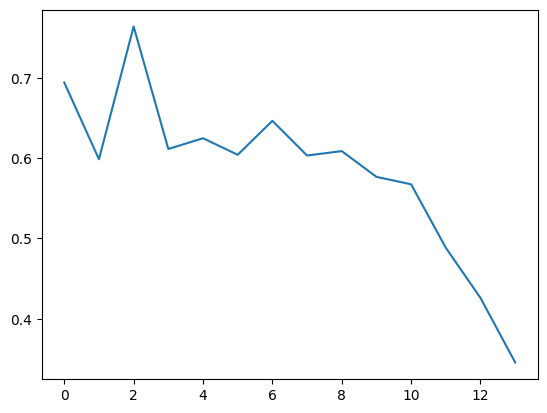

In [20]:
plt.plot(losses_train)

In [21]:
model.eval()

gold_labels = []
predictions = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = torch.LongTensor(batch['input_ids']).to(device)
        attn_masks = torch.Tensor(batch['attn_mask']).float().to(device)
        token_type_ids = torch.LongTensor(batch['token_type_ids']).to(device)

        visual_embeddings = torch.FloatTensor(batch['visual_embeddings']).to(device)
        visual_embeddings = visual_embeddings.squeeze()
        gold_label = batch['type'].to(device)

        outputs = model(input_ids.squeeze(1), attn_masks.squeeze(1), token_type_ids.squeeze(1), visual_embeddings)

        gold_labels.extend(gold_label.cpu().numpy())

        loss = loss_fn(outputs, gold_label.float())
        total_loss += loss.item()

        _, predicted_labels = torch.max(outputs, dim=1)

        predictions.extend(predicted_labels.cpu().numpy())

average_loss = total_loss / len(dataloader)
print(f'Average Loss: {average_loss}')

gold_labels = numpy.array(gold_labels)
predictions = numpy.array(predictions)

100%|██████████| 2/2 [01:02<00:00, 31.30s/it]

Average Loss: 0.5150370763407813


In [22]:
from sklearn.metrics import classification_report

report = classification_report(numpy.argmax(gold_labels, axis=1), predictions)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.81      0.68        64
           1       0.90      0.75      0.82       150

    accuracy                           0.77       214
   macro avg       0.74      0.78      0.75       214
weighted avg       0.81      0.77      0.77       214

